# Check all comment code duay and every detail

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2602454 Business Intelligence System</p>

# <p style="padding:20px; border:5px Outset #EBEBEB; background: linear-gradient(to right, #0099FF, #00FF7F); font-family:'Times_New_Roman'; text-align:left;padding: 20px; border: 2px solid #EBEBEB; font-size: 25px; color: #000; font-weight: bold">2602454 Business Intelligence System</p>


# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> Outline</p>

* [ 1. Import dataset and libraries ](#1)
    * [1.1 Data Cleaning](#1.1)
    * [1.2 Data summary](#1.2)
* [ 2. EDA](#2)

<a id="1"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 1. Import dataset and libraries</p>

In [1]:
import re
import os
import csv
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from ipywidgets import interact
import seaborn as sns
plt.rcParams['font.family'] = 'Tahoma'

In [2]:
def get_data(path):
    dir_path = path
    for filename in os.listdir(dir_path):
        if filename.endswith('.csv'):
            with open(os.path.join(dir_path, filename)) as csvfile:
                data = list(csv.reader(csvfile))
            yield data

def create_dataframe(data):
    for d in data:
        try:
            df = pd.DataFrame(d[1:], columns=d[0])
            yield df
        except Exception as e:
            print(f"Error creating DataFrame: {e}")

data = get_data('data/')
df_list = list(create_dataframe(data))
df = reduce(lambda df1,df2: pd.merge(df1,df2,how ='outer'), df_list)
df = df.iloc[:, 5:]

# Import data and convert it into 1 dataframe

In [3]:
def clean_space(df, columns: dict):
    df_copy = df.copy()
    for column in columns:
            df_copy[column] = df_copy[column].astype(str)
            df_copy[column] = df_copy[column].str.replace('\n', '').str.strip()
            df_copy[column] = df_copy[column].apply(lambda x: re.sub(r'\s{2,}', columns[column], x))
            yield column, df_copy[column]

def replace_column_data(df, columns_data: dict):
    df_replaced = df.copy()
    for key in columns_data.keys():
        df_replaced[key] = columns_data[key]
    return df_replaced

clean_columns = dict(clean_space(df, {"facility": ',', "space": ' '}))
df = replace_column_data(df, clean_columns)

<a id="1.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 1.1 Data Cleaning</p>

# Clean data

## clean empty data to NaN and change type of data to its correct type

In [4]:
df = df.replace(["null", "ไม่มีข้อมูล"], np.NaN)

df["price"] = df["price"].replace(r",", '', regex = True).astype(float)

df["space"] = df["space"].str.extract(r"([\d\.]+[\d+])").astype(float)

df["year"] = df["year"].str.extract(r"(\d{4})").astype(float)

df["bedroom"] = df["bedroom"].replace("สตูดิโอ", 0).astype(float)

df["bathroom"] = df["bathroom"].astype(float)

df["floor"] = df["floor"].astype(float)

In [5]:
df.rename(columns={"area (keat)": "area", "Province": "province"}, inplace=True)

## extract number distance from station and convert to float

In [6]:
def station(df):
    for i in range(len(df)):
        if isinstance(df['station'][i], float) and np.isnan(df['station'][i]):
            yield np.NaN, np.NaN, np.NaN
        else:
            match = re.search(r'สถานีใกล้เคียง\d+ นาที \((\d+) ม.\) ถึง (\w+)\s(\w+)\s[ก-๙]+', str(df['station'][i]))
            yield match.groups() if match else np.nan

test_df = pd.DataFrame(station(df))
test_df.columns = ['distance','station_id','station_type']
test_df["distance"] = test_df["distance"].astype(float)
df = pd.merge(df, test_df, left_index=True, right_index=True, how="left")
df = df.drop(columns="station")

## seperate each function of facility into their own category

In [7]:
def separate_facilities(df, **kwargs):
    for col_name, keywords in kwargs.items():
        df[col_name] = df["facility"].apply(lambda x: True if isinstance(x, str) and any(keyword in x for keyword in keywords) else False)
    return df

df = separate_facilities(df, 
                            is_Security = ['รักษาความปลอดภัย 24 ชม.','ระบบรักษาความาปลอดภัยการเข้า-ออกอาคาร'],
                            is_Laundry =['ซัก อบ รีด', 'เครื่องซักผ้า'],
                            is_Parking_Lot= ['ที่จอดรถ','ลานจอดรถ','ลานจอดรถใต้ดิน','โรงรถ'],
                            is_Bus_Stop= ['ป้ายรถเมล์'],
                            is_Cleaning=['พนักงานทำความสะอาด'],
                            is_Fitness =['ฟิตเนส','ลู่วิ่ง',],
                            is_Convenient_Store = ['มินิมาร์ท',],
                            is_Balcony=['ระเบียง',],
                            is_View = ['วิวทะเล','วิวสระว่ายน้ำ','วิวเมือง','สวน/วิวสวนธรรมชาติ'],
                            is_Sport_Facility = ['สนามบาส','สนามสควอช','สนามหัดเล่นกอล์ฟ','สนามเด็กเล่น','สนามเทนนิส','สนามแบดมินตัน','ห้องบิลเลียด','ห้องยิมนาสติก'],
                            is_Pool =['สปา สระว่ายน้ำ','สระว่ายน้ำ','สระว่ายน้ำส่วนตัว','สระว่ายน้ำเพื่อความสนุก','สระเด็ก',],
                            is_Park= ['สวนสาธารณะ',],
                            is_Garden = ['สวนส่วนตัว',],
                            is_corner_room = ['ห้องมุม',])

df = df.drop(columns="facility")

# Recheck ด้วย อันนี้ แค่คร่าวๆ

| Column Name   | Explanation                                     |
| ------------- | -------------------------------------------------|
| name          | Name of the property or listing                 |
| price         | Price of the property or listing                |
| province      | Province where the property is located          |
| area  | Area of the property in "keat" units            |
| district      | District where the property is located          |
| bedroom       | Number of bedrooms in the property             |
| bathroom      | Number of bathrooms in the property            |
| space         | Space or size of the property                  |
| year          | Year of construction or listing                |
| type          | Type of property (e.g., house, apartment, etc.)|
| furniture     | Information about the furniture in the property|
| floor         | Floor number or level of the property          |
| distance (m.) | Distance to a certain point (e.g., a station) in meters|
| station_type  | Type of nearby station (e.g., MRT, BTS, etc.)    |
| station_name  | Name of the nearby station                      |

# Delete Column 
ลบ column ที่ซ้ำซ้อน

In [8]:
df = df.drop(['province', 'station_type', 'area'], axis = 1)

In [9]:
df.head(3)

,name,price,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


## Clean name column

In [10]:
df["name"] = df["name"].str.extract(r"(?P<name>.+)[,]")
df["name"] = df["name"].str.extract(r"(?P<name>.+?[:]|.+)")
df["name"] = df["name"].str.replace(":", "").str.strip()

# Clean district column



In [11]:
district_name = {'The Met Sathorn' : 'ทุ่งมหาเมฆ',
 'ASHTON Silom : แอชตัน สีลม' : 'สุริยวงศ์',
 'Nara 9 สาทร-นราธิวาส': 'ทุ่งมหาเมฆ',
 'StarView Rama 3' : 'บางโคล่',
 'Villa Sathorn':'คลองต้นไทร',
 'The Park Chidlom' : 'ลุมพินี',
 r'M สีลม \(เอ็ม สีลม\)' : 'สุริยวงศ์',
 'Supalai Premier Ratchada-Narathiwas-Sathorn : ศุภาลัย พรีเมียร์ รัชดาฯ-นราธิวาส-สาทร' : 'ช่องนนทรี',
 r'Baan Nonsi \(บ้านนนทรี\)' : 'ช่องนนทรี',
 r'CU Terrace \(ระเบียงจามจุรี\)' : 'วังใหม่',
 'ปทุมวัน โอเอซิส คอนโดมิเนียม' : 'วังใหม่',
 'สุพรีม คลาสิค คอนโดมิเนียม' : 'ทุ่งมหาเมฆ'
 }
for key in district_name:
    df.loc[df['district'].str.contains(key), 'district'] = district_name[key]

df['district'].value_counts()

ลุมพินี            1584
ทุ่งมหาเมฆ          788
คลองต้นไทร          744
สีลม                708
ช่องนนทรี           584
บางโพงพาง           391
ยานนาวา             309
ดาวคะนอง            275
บางลำภูล่าง         256
ทุ่งวัดดอน          249
สี่พระยา            248
มหาพฤฒาราม          207
บุคคโล              185
บางโคล่             182
วัดพระยาไกร         155
ตลาดพลู             143
สุริยวงศ์           115
วังใหม่              94
บางคอแหลม            78
คลองสาน              62
สำเหร่               49
รองเมือง             38
สมเด็จเจ้าพระยา      10
ปทุมวัน               9
บางยี่เรือ            7
หิรัญรูจี             6
บางรัก                1
Name: district, dtype: int64

<a id="2"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2. EDA</p>

In [12]:
df.head(3)

,name,price,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


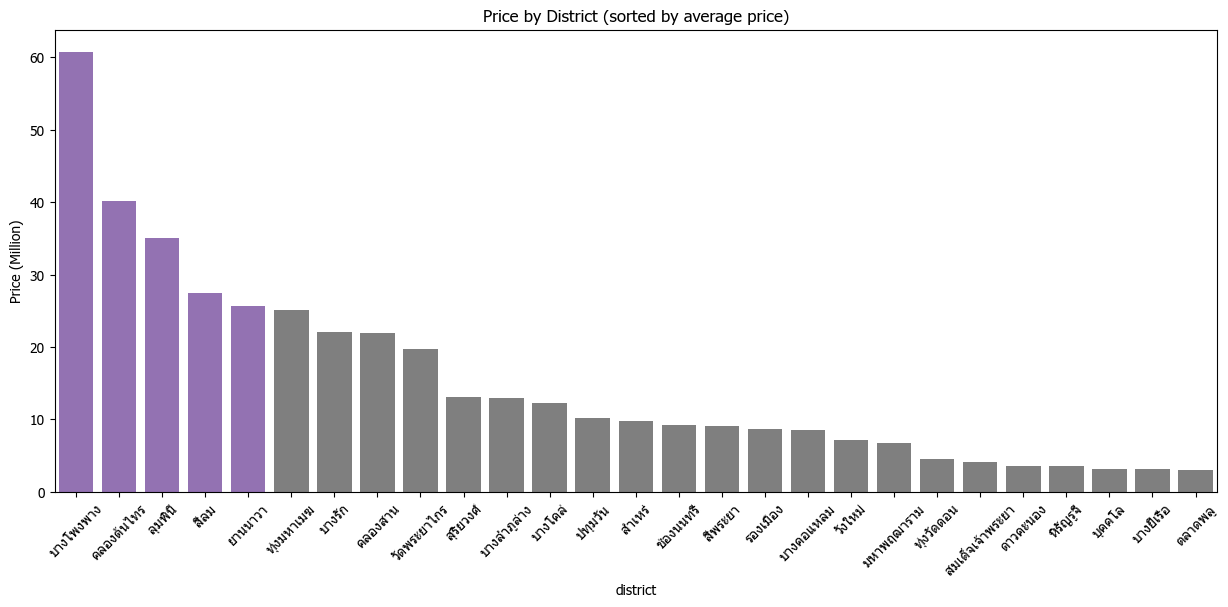

In [13]:
avg_price_by_district = df.groupby('district')['price'].mean().sort_values(ascending=False)

# create barplot with sorted order
plt.figure(figsize=(15,6))
color = ['tab:purple' if i < 5 else 'tab:grey' for i in range(len(df))]
sns.barplot(x=df['district'], y=df['price']/1e6, order=avg_price_by_district.index, errorbar=None, palette = color)
plt.title('Price by District (sorted by average price)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.ylabel("Price (Million)")
plt.show()

In [14]:
#pointplot --> price , district, year (interact)
district_names = df["district"].unique()
district_names# 

array(['บางคอแหลม', 'บางโคล่', 'วัดพระยาไกร', 'สีลม', 'สี่พระยา',
       'มหาพฤฒาราม', 'สุริยวงศ์', 'บางรัก', 'คลองต้นไทร', 'บางลำภูล่าง',
       'คลองสาน', 'สมเด็จเจ้าพระยา', 'ทุ่งมหาเมฆ', 'ยานนาวา',
       'ทุ่งวัดดอน', 'ช่องนนทรี', 'ลุมพินี', 'ปทุมวัน', 'รองเมือง',
       'วังใหม่', 'บุคคโล', 'ดาวคะนอง', 'สำเหร่', 'ตลาดพลู', 'หิรัญรูจี',
       'บางยี่เรือ', 'บางโพงพาง'], dtype=object)

In [15]:
@interact(District=district_names)
def price_year(District='ลุมพินี'):
    plt.figure(figsize=(10,5))
    graph = df[df['district'].isin([District])]

    year_data = graph[["year", "price"]].dropna() # drop NaN values and assign the returned DataFrame to year_data

    year_data['year'] = year_data['year'].apply(lambda x: '{:.0f}'.format(x))

    sns.pointplot(x=year_data["year"].astype(int), y=year_data['price'], color='indigo', errorbar=None)
    plt.title(f'Price distribution for {District}')
    plt.xticks(rotation=45)

    ax = plt.gca()

    def y_axis_numformat(y, pos):
        return "{:,.0f}".format(y)
    plt.ylim(0, None)

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_axis_numformat))
    plt.show();

interactive(children=(Dropdown(description='District', index=16, options=('บางคอแหลม', 'บางโคล่', 'วัดพระยาไกร…

In [16]:
rows = [312, 313, 1022, 1374, 2461, 3462, 3463, 3465, 3466, 3797, 6529, 6447, 925, 1931, 2461, 2744, 2745, 3210, 3221, 3331, 4557, 5428, 2822, 2897, 4092, 4269, 4354, 4413, 4591, 5175, 5191, 5527, 5594, 5628]
df = df.drop(index=rows)

In [17]:
plot_column = df[['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance']]
plot_column

,price,bedroom,bathroom,space,year,floor,distance
0,17500000.0,3.0,3.0,240.00,2006.0,NaN,720.0
1,19000000.0,3.0,3.0,230.00,2006.0,NaN,720.0
2,2500000.0,1.0,1.0,39.00,2004.0,NaN,150.0
3,3100000.0,1.0,1.0,40.00,2004.0,NaN,150.0
4,28500000.0,1.0,1.0,39.00,2004.0,NaN,150.0
...,...,...,...,...,...,...,...
7472,7490000.0,3.0,3.0,142.00,2014.0,6.0,450.0
7473,2350000.0,1.0,1.0,28.74,2011.0,34.0,460.0
7474,5500000.0,2.0,2.0,94.00,2007.0,7.0,560.0
7475,12500000.0,2.0,2.0,165.67,NaN,45.0,950.0


## Box plot to check value outliner

In [18]:
columns_name = ["price", 'bedroom', 'bathroom', 'space', 'year', 'floor', 'distance']
@interact(column=columns_name)
def price_year(column):
    df.boxplot(column=column)

    plt.ylabel(column)
    plt.title('Box Plot from DataFrame')

    plt.show()

interactive(children=(Dropdown(description='column', options=('price', 'bedroom', 'bathroom', 'space', 'year',…

## clean wrong outliner

### recheck duay

In [19]:
df.loc[4564, "floor"] = 15 #ตึกไม่สูงพอ
df.loc[2662, "space"] = 605 #ตึกไม่กว้างพอ (เทียบกับห้องอื่นโครงเดียวกัน)
df.loc[7076, "price"] = 19_800_000 #แพงไปไม่มีใครซื้อ

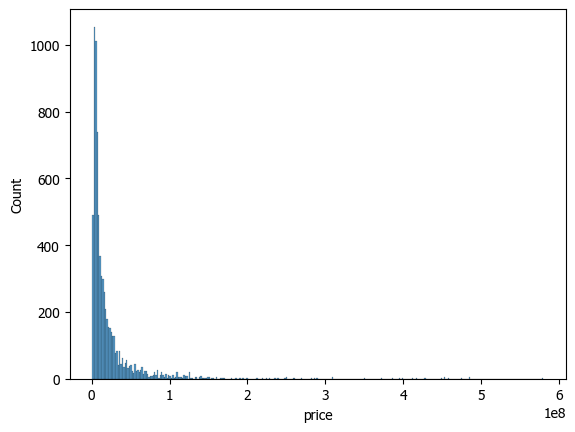

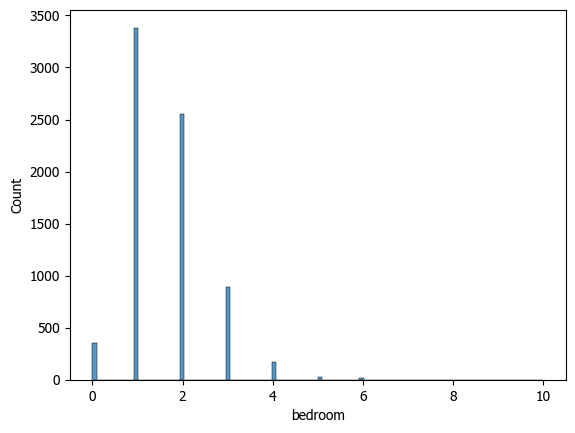

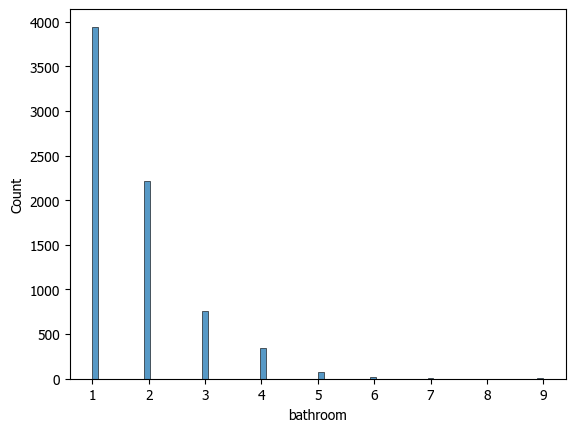

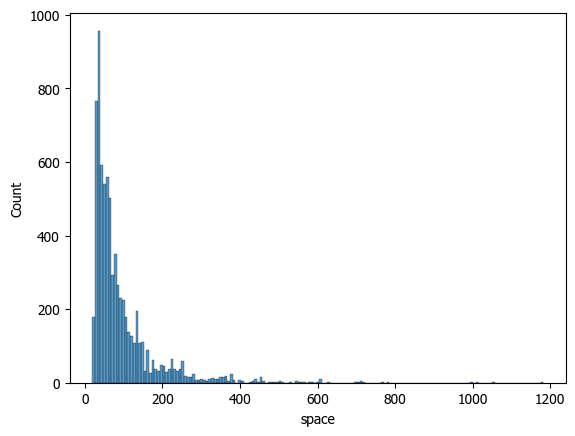

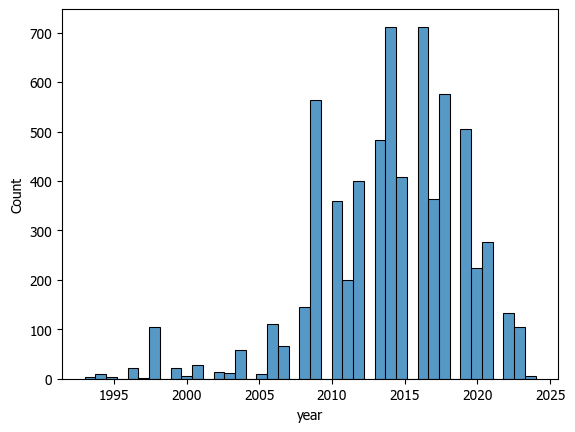

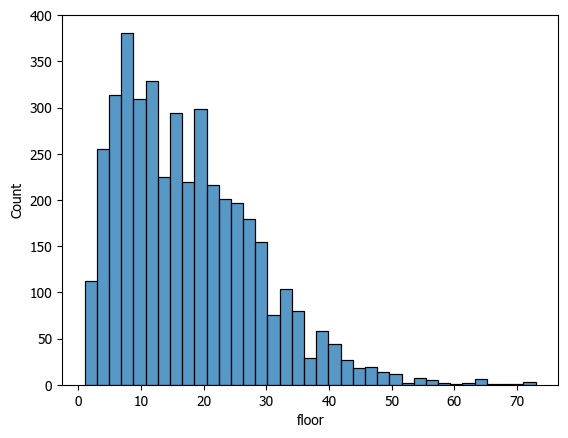

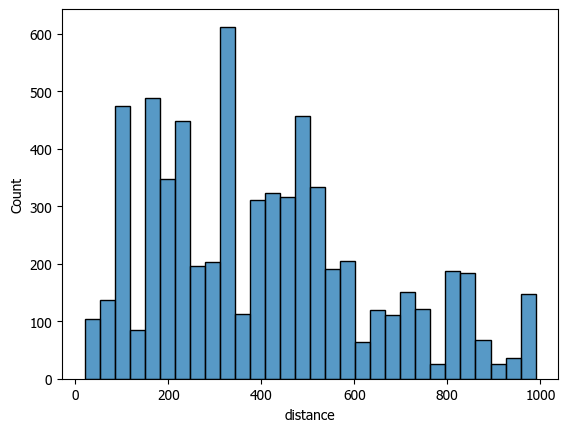

In [20]:
for plots in plot_column.columns:
    sns.histplot(df[plots])
    plt.show()

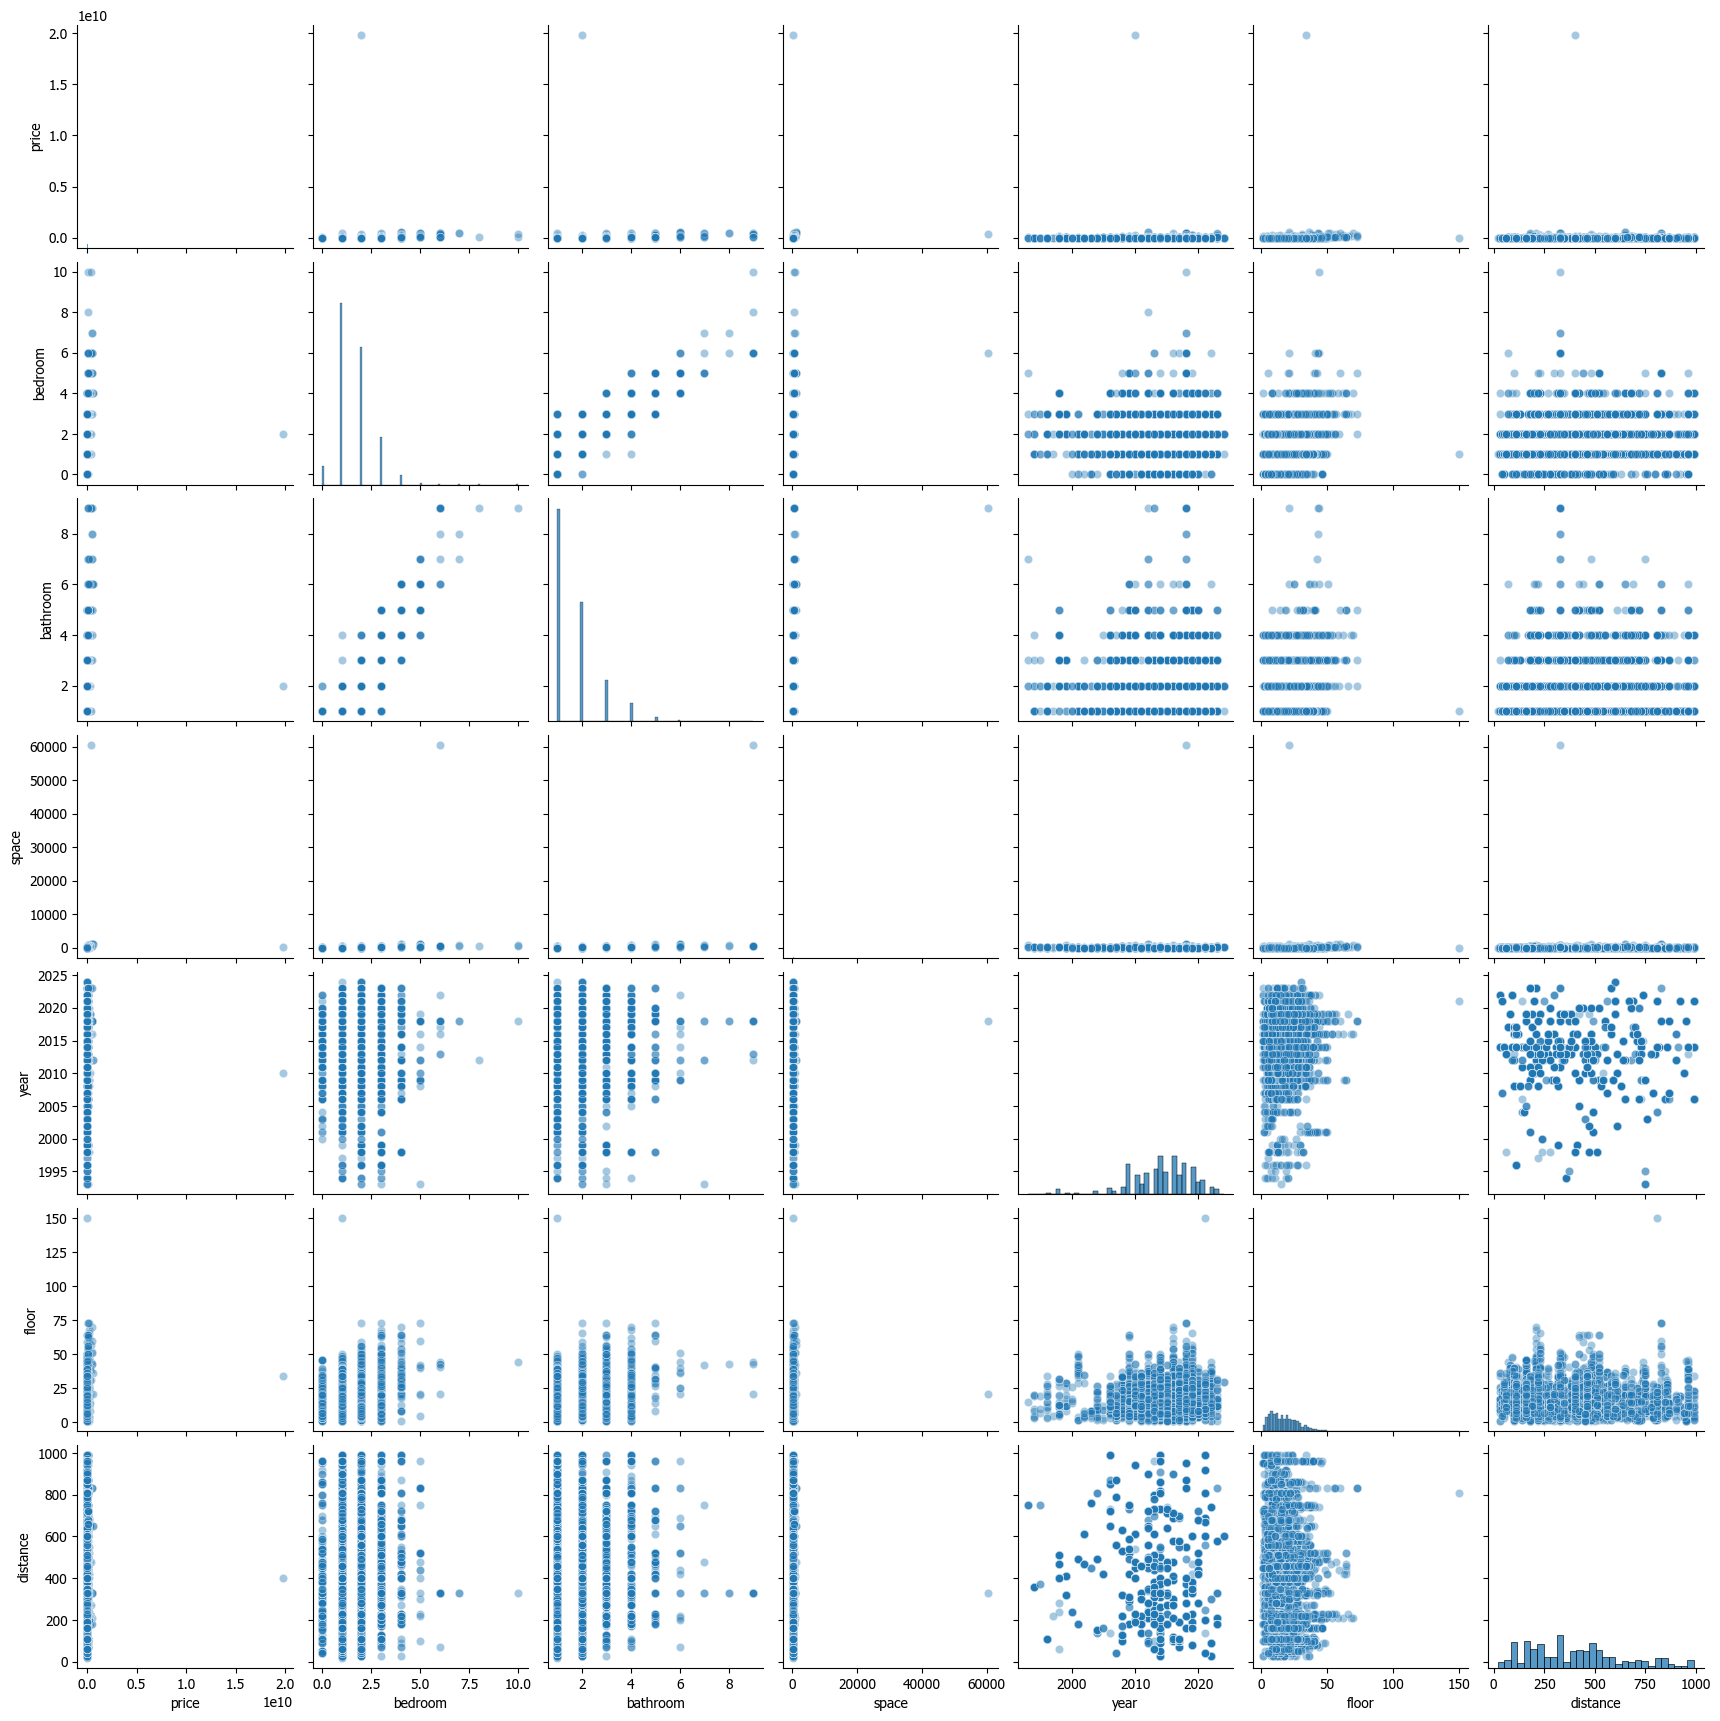

<Figure size 640x480 with 0 Axes>

In [21]:
sns.pairplot(plot_column, vars=['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance'], 
             plot_kws={'alpha': .4})
plt.show()
plt.clf()

# LabelEncoder ( เป็น order )

`ตกแต่งครบ    2
มีบางส่วน     1
ไม่มี         0`

In [22]:
df['furniture'].unique()

array([nan, 'ตกแต่งครบ', 'มีบางส่วน', 'ไม่มี'], dtype=object)

In [23]:
furniture = {'ตกแต่งครบ' : 2, 'มีบางส่วน' : 1, 'ไม่มี' : 0}

df['furniture_encoded'] = df['furniture'].map(furniture)
df = df.drop('furniture', axis =1 )
df.head(5)


,name,price,district,bedroom,bathroom,space,year,type,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
3,Lumpini Place Rama 3 - Riverview,3100000.0,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
4,Lumpini Place Rama 3 - Riverview,28500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN


# Change categorical column to one-hot encoding

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7444 entries, 0 to 7476
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 7435 non-null   object 
 1   price                7436 non-null   float64
 2   district             7444 non-null   object 
 3   bedroom              7391 non-null   float64
 4   bathroom             7369 non-null   float64
 5   space                7441 non-null   float64
 6   year                 6641 non-null   float64
 7   type                 6642 non-null   object 
 8   floor                4195 non-null   float64
 9   distance             6583 non-null   float64
 10  station_id           6583 non-null   object 
 11  is_Security          7444 non-null   bool   
 12  is_Laundry           7444 non-null   bool   
 13  is_Parking_Lot       7444 non-null   bool   
 14  is_Bus_Stop          7444 non-null   bool   
 15  is_Cleaning          7444 non-null   b

In [25]:
df1 = df.copy()

In [26]:
category_column = ['type','station_id']

In [27]:
df_dummy = pd.get_dummies(df['district'], prefix='แขวง',prefix_sep='' ,drop_first=True)
df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
df = df.drop('district', axis = 1)

In [28]:
for col in category_column:
    df_dummy = pd.get_dummies(df[col], drop_first=True)
    df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
    df = df.drop(col, axis = 1)

In [29]:
df.head()

,name,price,bedroom,bathroom,space,year,floor,distance,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded,แขวงคลองสาน,แขวงช่องนนทรี,แขวงดาวคะนอง,แขวงตลาดพลู,แขวงทุ่งมหาเมฆ,แขวงทุ่งวัดดอน,แขวงบางคอแหลม,แขวงบางยี่เรือ,แขวงบางรัก,แขวงบางลำภูล่าง,แขวงบางโคล่,แขวงบางโพงพาง,แขวงบุคคโล,แขวงปทุมวัน,แขวงมหาพฤฒาราม,แขวงยานนาวา,แขวงรองเมือง,แขวงลุมพินี,แขวงวังใหม่,แขวงวัดพระยาไกร,แขวงสมเด็จเจ้าพระยา,แขวงสำเหร่,แขวงสีลม,แขวงสี่พระยา,แขวงสุริยวงศ์,แขวงหิรัญรูจี,เช่าซื้อระยะยาว 30 ปี,เช่าระยะยาว,B10,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,BL24,BL25,BL26,BL27,BL28,BL30,E1,E14,E2,E3,G2,G3,RN07,S1,S10,S11,S2,S3,S4,S5,S6,S7,S8,S9,W1
0,Supalai Casa Riva,17500000.0,3.0,3.0,240.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Supalai Casa Riva,19000000.0,3.0,3.0,230.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lumpini Place Rama 3 - Riverview,2500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lumpini Place Rama 3 - Riverview,3100000.0,1.0,1.0,40.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lumpini Place Rama 3 - Riverview,28500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df.shape

(7444, 87)

# Model

In [31]:
df['price'].dropna(inplace=True)

In [32]:
df.dropna(subset=['price'], inplace=True)


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7436 entries, 0 to 7476
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   7427 non-null   object 
 1   price                  7436 non-null   float64
 2   bedroom                7386 non-null   float64
 3   bathroom               7364 non-null   float64
 4   space                  7435 non-null   float64
 5   year                   6634 non-null   float64
 6   floor                  4190 non-null   float64
 7   distance               6576 non-null   float64
 8   is_Security            7436 non-null   bool   
 9   is_Laundry             7436 non-null   bool   
 10  is_Parking_Lot         7436 non-null   bool   
 11  is_Bus_Stop            7436 non-null   bool   
 12  is_Cleaning            7436 non-null   bool   
 13  is_Fitness             7436 non-null   bool   
 14  is_Convenient_Store    7436 non-null   bool   
 15  is_B

In [34]:
df.shape

(7436, 87)

## Spilt train test

In [35]:
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['price', 'name'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

---
## Instantiate the different regression models

In [36]:
from sklearn.metrics import mean_squared_error
from flaml import AutoML
from math import sqrt


## FLAML Find best model and param

In [37]:
# Instantiate AutoML object
automl = AutoML()

# Define the search space for hyperparameters for regression
automl_settings = {
    "time_budget": 120,  # maximum time in seconds for training
    "metric": 'r2',
    "task": "regression",  # specify the task type as regression
    "log_file_name": "automl.log",  # log file to record the training progress
    "n_splits": 5,  # number of cross-validation folds
    "eval_method": "auto",  # specify evaluation metric as auto for regression
    "split_type": "uniform",  # type of train-test split for cross-validation
    "model_history": True,  # record model training history
    "n_jobs": 2,  # number of parallel jobs to run during training
    "estimator_list": ['lgbm', 'xgboost', 'catboost', 'xgb_limitdepth']
}

# Search for the best model and hyperparameters for regression
automl.fit(
    X_train=X_train,
    y_train=y_train,
    **automl_settings
)

#Predict
print(automl.predict(X_train))

# Access the best model and hyperparameters
best_model = automl.model.estimator
# best_log = automl.best_log


# Check if best_model is not None before accessing the best hyperparameters
if best_model is not None:
    # Print the best model and hyperparameters
    print(f"Best model: {best_model}")
    # print(f"Best hyperparameters: {best_log}")
else:
    print("No best model found.")


[flaml.automl.logger: 04-16 14:41:33] {1768} INFO - task = regression
[flaml.automl.logger: 04-16 14:41:33] {1775} INFO - Data split method: uniform
[flaml.automl.logger: 04-16 14:41:33] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-16 14:41:33] {1891} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 04-16 14:41:33] {2011} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost', 'xgb_limitdepth']
[flaml.automl.logger: 04-16 14:41:33] {2341} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-16 14:41:33] {2479} INFO - Estimated sufficient time budget=240s. Estimated necessary time budget=2s.
[flaml.automl.logger: 04-16 14:41:33] {2526} INFO -  at 0.2s,	estimator lgbm's best error=0.6403,	best estimator lgbm's best error=0.6403
[flaml.automl.logger: 04-16 14:41:33] {2341} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-16 14:41:33] {2526} INFO -  at 0.3s,	estimator lgbm's best error=0.6403,	best estimator lgb

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:36] {2526} INFO -  at 2.7s,	estimator catboost's best error=0.0226,	best estimator catboost's best error=0.0226
[flaml.automl.logger: 04-16 14:41:36] {2341} INFO - iteration 42, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:37] {2526} INFO -  at 3.7s,	estimator catboost's best error=0.0226,	best estimator catboost's best error=0.0226
[flaml.automl.logger: 04-16 14:41:37] {2341} INFO - iteration 43, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:37] {2526} INFO -  at 4.3s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:37] {2341} INFO - iteration 44, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:37] {2526} INFO -  at 4.4s,	estimator xgb_limitdepth's best error=0.0280,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:37] {2341} INFO - iteration 45, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:38] {2526} INFO -  at 4.5s,	estimator xgb_limitdepth's best error=0.0280,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:38] {2341} INFO - iteration 46, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:38] {2526} INFO -  at 4.6s,	estimator xgb_limitdepth's best error=0.0280,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:38] {2341} INFO - iteration 47, current learner xgb_limitdepth
[flaml.aut

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:38] {2526} INFO -  at 5.1s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:38] {2341} INFO - iteration 49, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:38] {2526} INFO -  at 5.3s,	estimator xgb_limitdepth's best error=0.0280,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:38] {2341} INFO - iteration 50, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:38] {2526} INFO -  at 5.3s,	estimator xgb_limitdepth's best error=0.0280,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:38] {2341} INFO - iteration 51, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:39] {2526} INFO -  at 6.0s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:39] {2341} INFO - iteration 52, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:40] {2526} INFO -  at 7.1s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:40] {2341} INFO - iteration 53, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:41] {2526} INFO -  at 7.5s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:41] {2341} INFO - iteration 54, current learner lgbm
[flaml.automl.logger: 04-16 14:41:41] {2526} INFO -  at 7.5s,	estimator lgbm's best error=0.0334,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:41] {2341} INFO - iteration 55, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:41] {2526} INFO -  at 7.7s,	estimator xgb_limitdepth's best error=0.0280,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:41] {2341} INFO - iteration 56, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:42] {2526} INFO -  at 8.5s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:42] {2341} INFO - iteration 57, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:42] {2526} INFO -  at 8.6s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:42] {2341} INFO - iteration 58, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:42] {2526} INFO -  at 9.0s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:42] {2341} INFO - iteration 59, current learner lgbm
[flaml.automl.logger: 04-16 14:41:42] {2526} INFO -  at 9.0s,	estimator lgbm's best error=0.0334,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:42] {2341} INFO - iteration 60, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:42] {2526} INFO -  at 9.3s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:42] {2341} INFO - iteration 61, current learner xgboost
[flaml.automl.logger: 04-16 14:41:42] {2526} INFO -  at 9.4s,	estimator xgboost's best error=0.0764,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:42] {2341} INFO - iteration 62, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:43] {2526} INFO -  at 10.1s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:43] {2341} INFO - iteration 63, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:44] {2526} INFO -  at 11.0s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:44] {2341} INFO - iteration 64, current learner lgbm
[flaml.automl.logger: 04-16 14:41:44] {2526} INFO -  at 11.0s,	estimator lgbm's best error=0.0334,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:44] {2341} INFO - iteration 65, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:45] {2526} INFO -  at 11.8s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:45] {2341} INFO - iteration 66, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:45] {2526} INFO -  at 12.0s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:45] {2341} INFO - iteration 67, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:46] {2526} INFO -  at 12.6s,	estimator catboost's best error=0.0217,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:46] {2341} INFO - iteration 68, current learner lgbm
[flaml.automl.logger: 04-16 14:41:46] {2526} INFO -  at 12.7s,	estimator lgbm's best error=0.0334,	best estimator catboost's best error=0.0217
[flaml.automl.logger: 04-16 14:41:46] {2341} INFO - iteration 69, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:47] {2526} INFO -  at 13.6s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:47] {2341} INFO - iteration 70, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:47] {2526} INFO -  at 14.4s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:47] {2341} INFO - iteration 71, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:48] {2526} INFO -  at 15.0s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:48] {2341} INFO - iteration 72, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:48] {2526} INFO -  at 15.1s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:48] {2341} INFO - iteration 73, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:49] {2526} INFO -  at 15.5s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:49] {2341} INFO - iteration 74, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:49] {2526} INFO -  at 15.7s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:49] {2341} INFO - iteration 75, current learner lgbm
[flaml.automl.logger: 04-16 14:41:49] {2526} INFO -  at 15.7s,	estimator lgbm's best error=0.0334,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:49] {2341} INFO - iteration 76, current learner lgbm
[flaml.automl.logger: 04-16 14:41:49] {2526} INFO -  at 15.8s,	estimator lgbm's best error=0.0334,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:49] {2341} INFO - iteration 77, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:49] {2526} INFO -  at 16.3s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:49] {2341} INFO - iteration 78, current learner xgboost
[flaml.automl.logger: 04-16 14:41:49] {2526} INFO -  at 16.3s,	estimator xgboost's best error=0.0764,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:49] {2341} INFO - iteration 79, current learner xgboost
[flaml.automl.logger: 04-16 14:41:49] {2526} INFO -  at 16.4s,	estimator xgboost's best error=0.0764,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:49] {2341} INFO - iteration 80, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:50] {2526} INFO -  at 16.5s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:50] {2341} INFO - iteration 81, current learner xgboost
[flaml.automl.logger: 04-16 14:41:50] {25

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:50] {2526} INFO -  at 17.0s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:50] {2341} INFO - iteration 83, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:51] {2526} INFO -  at 17.5s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:51] {2341} INFO - iteration 84, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:51] {2526} INFO -  at 17.6s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:51] {2341} INFO - iteration 85, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:51] {2526} INFO -  at 18.1s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:51] {2341} INFO - iteration 86, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:52] {2526} INFO -  at 18.6s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:52] {2341} INFO - iteration 87, current learner xgboost
[flaml.automl.logger: 04-16 14:41:52] {2526} INFO -  at 18.7s,	estimator xgboost's best error=0.0764,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:52] {2341} INFO - iteration 88, current learner xgboost
[flaml.automl.logger: 04-16 14:41:52] {2526} INFO -  at 18.7s,	estimator xgboost's best error=0.0764,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:52] {2341} INFO - iteration 89, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:52] {2526} INFO -  at 18.9s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:52] {2341} INFO - iteration 90, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:52] {2526} INFO -  at 19.3s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:52] {2341} INFO - iteration 91, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:41:52] {2526} INFO -  at 19.4s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:52] {2341} INFO - iteration 92, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:57] {2526} INFO -  at 23.6s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:57] {2341} INFO - iteration 93, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:41:59] {2526} INFO -  at 26.4s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:41:59] {2341} INFO - iteration 94, current learner lgbm
[flaml.automl.logger: 04-16 14:42:00] {2526} INFO -  at 26.5s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:00] {2341} INFO - iteration 95, current learner lgbm
[flaml.automl.logger: 04-16 14:42:00] {2526} INFO -  at 26.5s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:00] {2341} INFO - iteration 96, current learner lgbm
[flaml.automl.logger: 04-16 14:42:00] {2526} INFO -  at 26.6s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:00] {2341} INFO - iteration 97, current learner lgbm
[flaml.automl.logger: 04-16 14:42:00] {2526} INFO -  at 26.7s,	estimator lgb

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:05] {2526} INFO -  at 31.4s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:05] {2341} INFO - iteration 122, current learner lgbm
[flaml.automl.logger: 04-16 14:42:05] {2526} INFO -  at 31.5s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:05] {2341} INFO - iteration 123, current learner lgbm
[flaml.automl.logger: 04-16 14:42:05] {2526} INFO -  at 31.5s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:05] {2341} INFO - iteration 124, current learner lgbm
[flaml.automl.logger: 04-16 14:42:05] {2526} INFO -  at 31.6s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:05] {2341} INFO - iteration 125, current learner lgbm
[flaml.automl.logger: 04-16 14:42:05] {2526} INFO -  at 31.7s,	estimator

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:11] {2526} INFO -  at 37.5s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:11] {2341} INFO - iteration 164, current learner lgbm
[flaml.automl.logger: 04-16 14:42:11] {2526} INFO -  at 37.5s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:11] {2341} INFO - iteration 165, current learner lgbm
[flaml.automl.logger: 04-16 14:42:11] {2526} INFO -  at 37.6s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:11] {2341} INFO - iteration 166, current learner lgbm
[flaml.automl.logger: 04-16 14:42:11] {2526} INFO -  at 37.6s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:11] {2341} INFO - iteration 167, current learner xgboost
[flaml.automl.logger: 04-16 14:42:11] {2526} INFO -  at 37.8s,	estima

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:17] {2526} INFO -  at 44.2s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:17] {2341} INFO - iteration 190, current learner lgbm
[flaml.automl.logger: 04-16 14:42:17] {2526} INFO -  at 44.2s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:17] {2341} INFO - iteration 191, current learner lgbm
[flaml.automl.logger: 04-16 14:42:17] {2526} INFO -  at 44.3s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:17] {2341} INFO - iteration 192, current learner lgbm
[flaml.automl.logger: 04-16 14:42:17] {2526} INFO -  at 44.3s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:17] {2341} INFO - iteration 193, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:20] {2526} INFO -  at 47.1s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:20] {2341} INFO - iteration 194, current learner lgbm
[flaml.automl.logger: 04-16 14:42:20] {2526} INFO -  at 47.2s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:20] {2341} INFO - iteration 195, current learner lgbm
[flaml.automl.logger: 04-16 14:42:20] {2526} INFO -  at 47.3s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:20] {2341} INFO - iteration 196, current learner lgbm
[flaml.automl.logger: 04-16 14:42:20] {2526} INFO -  at 47.3s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:20] {2341} INFO - iteration 197, current learner xgboost
[flaml.automl.logger: 04-16 14:42:20] {2526} INFO -  at 47.4s,	estima

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:24] {2526} INFO -  at 50.9s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:24] {2341} INFO - iteration 199, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:25] {2526} INFO -  at 52.4s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:25] {2341} INFO - iteration 200, current learner lgbm
[flaml.automl.logger: 04-16 14:42:25] {2526} INFO -  at 52.4s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:25] {2341} INFO - iteration 201, current learner lgbm
[flaml.automl.logger: 04-16 14:42:25] {2526} INFO -  at 52.4s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:25] {2341} INFO - iteration 202, current learner lgbm
[flaml.automl.logger: 04-16 14:42:26] {2526} INFO -  at 52.5s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:26] {2341} INFO - iteration 203, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:42:26] {2526} INFO -  at 52.6s,

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:29] {2526} INFO -  at 55.6s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:29] {2341} INFO - iteration 207, current learner lgbm
[flaml.automl.logger: 04-16 14:42:29] {2526} INFO -  at 55.6s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:29] {2341} INFO - iteration 208, current learner lgbm
[flaml.automl.logger: 04-16 14:42:29] {2526} INFO -  at 55.7s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:29] {2341} INFO - iteration 209, current learner lgbm
[flaml.automl.logger: 04-16 14:42:29] {2526} INFO -  at 55.7s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:29] {2341} INFO - iteration 210, current learner lgbm
[flaml.automl.logger: 04-16 14:42:29] {2526} INFO -  at 55.8s,	estimator

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:30] {2526} INFO -  at 57.4s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:30] {2341} INFO - iteration 213, current learner catboost


c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:33] {2526} INFO -  at 60.0s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:33] {2341} INFO - iteration 214, current learner lgbm
[flaml.automl.logger: 04-16 14:42:33] {2526} INFO -  at 60.1s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:33] {2341} INFO - iteration 215, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:42:33] {2526} INFO -  at 60.2s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:33] {2341} INFO - iteration 216, current learner lgbm
[flaml.automl.logger: 04-16 14:42:33] {2526} INFO -  at 60.2s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:33] {2341} INFO - iteration 217, current learner lgbm
[flaml.automl.logger: 04-16 14:42:33] {2526} INFO - 

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:39] {2526} INFO -  at 66.1s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:39] {2341} INFO - iteration 254, current learner lgbm
[flaml.automl.logger: 04-16 14:42:39] {2526} INFO -  at 66.2s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:39] {2341} INFO - iteration 255, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:42:39] {2526} INFO -  at 66.3s,	estimator xgb_limitdepth's best error=0.0273,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:39] {2341} INFO - iteration 256, current learner lgbm
[flaml.automl.logger: 04-16 14:42:39] {2526} INFO -  at 66.3s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:39] {2341} INFO - iteration 257, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:42:40] {252

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:42:44] {2526} INFO -  at 70.9s,	estimator catboost's best error=0.0204,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:44] {2341} INFO - iteration 286, current learner xgboost
[flaml.automl.logger: 04-16 14:42:44] {2526} INFO -  at 71.1s,	estimator xgboost's best error=0.0257,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:44] {2341} INFO - iteration 287, current learner lgbm
[flaml.automl.logger: 04-16 14:42:44] {2526} INFO -  at 71.2s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:44] {2341} INFO - iteration 288, current learner lgbm
[flaml.automl.logger: 04-16 14:42:44] {2526} INFO -  at 71.2s,	estimator lgbm's best error=0.0214,	best estimator catboost's best error=0.0204
[flaml.automl.logger: 04-16 14:42:44] {2341} INFO - iteration 289, current learner xgboost
[flaml.automl.logger: 04-16 14:42:44] {2526} INFO -  at 71.3s,	

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:43:06] {2526} INFO -  at 93.0s,	estimator catboost's best error=0.0204,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:06] {2341} INFO - iteration 416, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:43:06] {2526} INFO -  at 93.3s,	estimator xgb_limitdepth's best error=0.0205,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:06] {2341} INFO - iteration 417, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:43:07] {2526} INFO -  at 94.2s,	estimator xgb_limitdepth's best error=0.0205,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:07] {2341} INFO - iteration 418, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:43:08] {2526} INFO -  at 94.8s,	estimator xgb_limitdepth's best error=0.0205,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:08] {2341} INFO - iteration 419, current learner lgbm
[flaml.automl.lo

c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2008: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_tr, y_tr = X_train[:n], y_train[:n]
c:\Users\USER\miniconda3\lib\site-packages\flaml\automl\model.py:2012: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Pool(data=X_train[n:], label=y_train[n:], cat_features=cat_features)


[flaml.automl.logger: 04-16 14:43:20] {2526} INFO -  at 106.9s,	estimator catboost's best error=0.0204,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:20] {2341} INFO - iteration 460, current learner xgb_limitdepth
[flaml.automl.logger: 04-16 14:43:21] {2526} INFO -  at 107.7s,	estimator xgb_limitdepth's best error=0.0205,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:21] {2341} INFO - iteration 461, current learner lgbm
[flaml.automl.logger: 04-16 14:43:21] {2526} INFO -  at 107.7s,	estimator lgbm's best error=0.0214,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:21] {2341} INFO - iteration 462, current learner lgbm
[flaml.automl.logger: 04-16 14:43:21] {2526} INFO -  at 107.7s,	estimator lgbm's best error=0.0214,	best estimator xgboost's best error=0.0177
[flaml.automl.logger: 04-16 14:43:21] {2341} INFO - iteration 463, current learner lgbm
[flaml.automl.logger: 04-16 14:43:21] {2526} INFO - 

In [38]:
def display_model_score(model):

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("-"*50)
    print(model.__class__.__name__)
    print("-"*50)
    print(f"Coefficient of Determination")
    print(f"train score : {model.score(X_train, y_train)}")
    print(f"test  score : {model.score(X_test, y_test)}")
    print("-"*50)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", sqrt(mse))
    print("-"*50)

In [39]:
def display_important_feature(models):
    importances = models.feature_importances_
    indices = np.argsort(importances)
    features = X.columns
    plt.figure(figsize=(15, 15))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

--------------------------------------------------
XGBRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9946481743512053
test  score : 0.9223890283483599
--------------------------------------------------
Mean Squared Error: 105855608780144.1
Root Mean Squared Error: 10288615.493842896
--------------------------------------------------


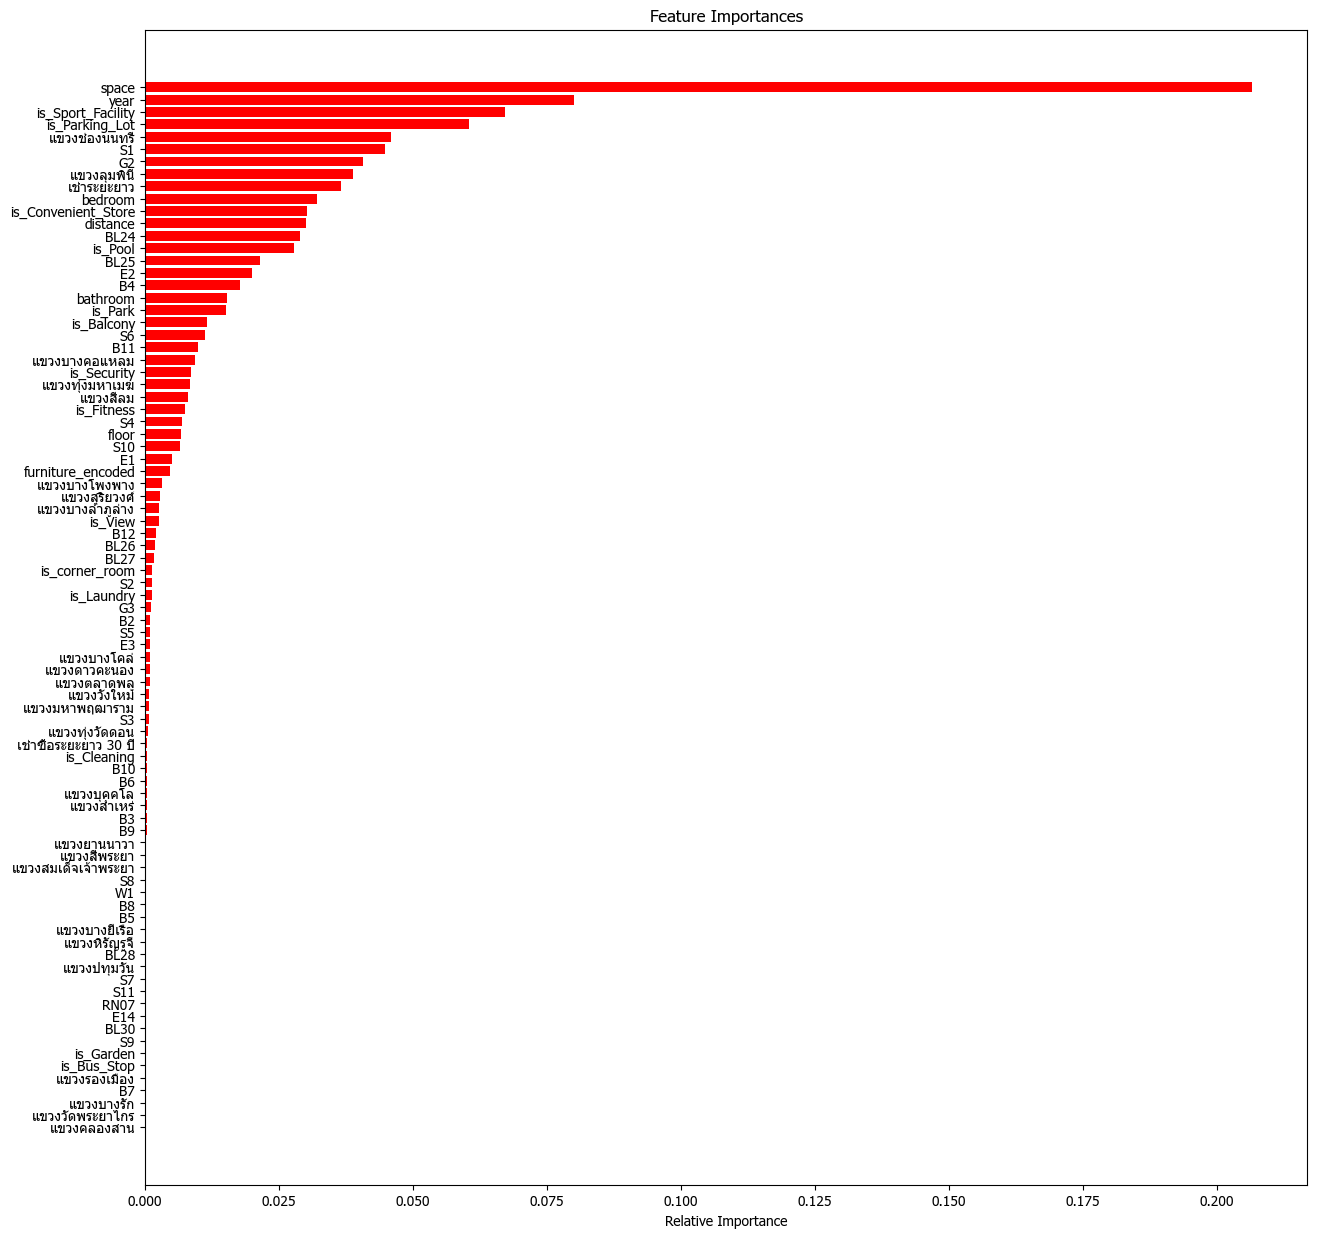

In [40]:
best_model.fit(X_train, y_train)
display_model_score(best_model)
display_important_feature(best_model)